In [1]:
from monai import transforms as mtf
import monai.transforms.spatial.functional as mtsf
import torch
from contextlib import nullcontext
import joblib
from typing import Any
import numpy as np, os, shutil
from tqdm.notebook import tqdm
from glio import transforms as gtf
from glio.torch_tools import area_around, center_of_mass, to_binary
from glio.datasets.BRaTS2024 import Preprocessor
from glio.data import DSToTarget
from glio.loaders import niiread, niireadtensor
from glio.transforms import norm_to01, z_normalize, z_normalize_channels
from torchvision.transforms import v2
from glio.jupyter_tools import show_slices, show_slices_arr
from glio.visualize import Visualizer, vis_imshow, vis_imshow_grid
from glio.plot import *
from glio.python_tools import listdir_fullpaths, find_file_containing, SliceContainer, get0, get1
from glio.progress_bar import PBar
from glio.mri.preprocess_datasets import preprocess_rhuh as process_rhuh

d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Оригинал

(240, 240, 155) = 


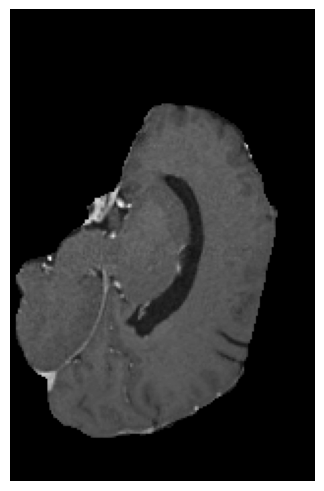

In [2]:
img = niiread(r"E:\dataset\RHUH-GBM\RHUH-GBM_nii_v1\RHUH-0001\1\RHUH-0001_1_t1ce.nii.gz")
print(f"{img.shape} = ")
qimshow(img[100])

# Объект без фона

-5.125698357256245e-17 0.9999998592817636
(4, 144, 175, 141) (144, 175, 141)


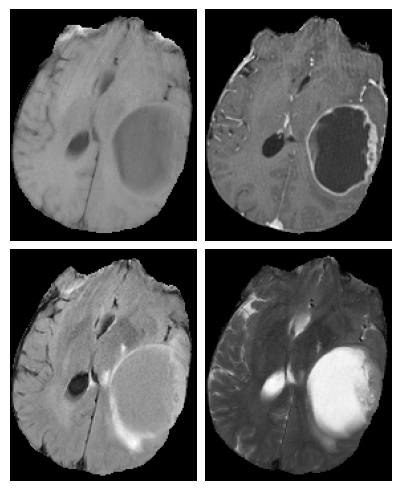

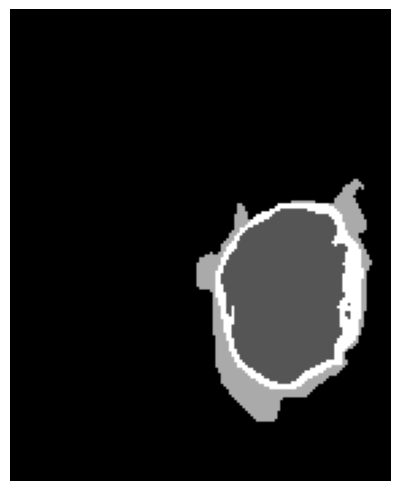

In [3]:
arr, seg = process_rhuh(r'E:\dataset\RHUH-GBM\RHUH-GBM_nii_v1\RHUH-0001\0')
print(arr.mean(), arr.std())
print(arr.shape, seg.shape)
qimshow_grid(arr[:, 80])
qimshow(seg[80])

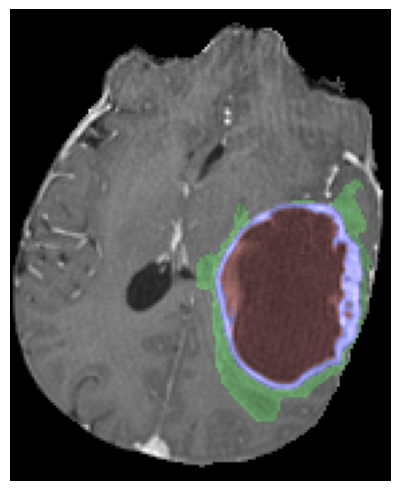

In [4]:
from glio.specific.vkr import visualize_3_segm_classes
qimshow(visualize_3_segm_classes(torch.from_numpy(arr)[1][80], torch.from_numpy(seg.astype(np.int32))[80], magn=1.5))

# Результаты

# Ориентация изображения

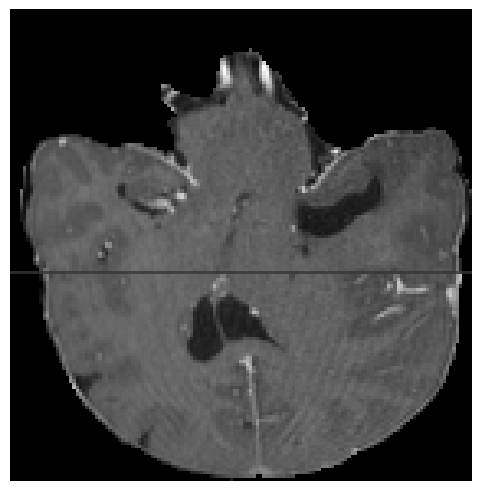

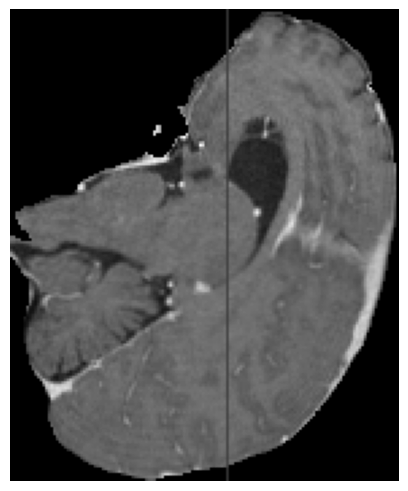

In [5]:
qimshow(arr[1].swapaxes(0,1)[70])
qimshow(arr[1].swapaxes(0,2)[70])

# Предсохранение

ZipStore со следующей стуктурой:

- Каждая группа по названию обследования включает массивы: `side`, `side_seg`, `side_centers`, `top`, ..., `front`, ...

- Структура `side`/`front`/`top`: Массив размером (2, 4, 140*, 180*, 140*)
    1. [nohist, hist] 
    2. [t1c, t1n, t2f, t2w] 
    3. [*срезы] 
    4. [*h] 
    5. [*w]



In [6]:
RHUH_PATH = r"E:\dataset\RHUH-GBM\RHUH-GBM_nii_v1"

dstrain = []
dstest = []

for obs_i, study in enumerate(PBar(listdir_fullpaths(RHUH_PATH), step=1)):
    for obs in listdir_fullpaths(study):
        print(obs, end='        \r')

        # get all paths
        images, segmentations = process_rhuh(obs)
        images = torch.from_numpy(images)
        segmentations = torch.from_numpy(segmentations.astype(np.int32))

        #images = area_around(images, center, (SIZE, SIZE, SIZE)).to(torch.float16).clone()
        #segmentations = area_around(segmentations, center, (SIZE, SIZE, SIZE)).to(torch.uint8).clone()
        images = images.to(torch.float16).clone()
        segmentations = segmentations.to(torch.uint8).clone()

        samples = []
        # save top
        slices = []
        for i, sl in enumerate(to_binary(segmentations, 0)):
            if sl.sum() > 0:
                # save center and seg
                slices.append((SliceContainer(images, (slice(None), i)), SliceContainer(segmentations, i)))
        samples.append(slices)

        # save front
        slices = []
        for i, sl in enumerate(to_binary(segmentations.swapaxes(0,1), 0)):
            if sl.sum() > 0:
                # save center and seg
                slices.append((SliceContainer(images, (slice(None),slice(None), i)), SliceContainer(segmentations, (slice(None), i))))
        samples.append(slices)

        # save side
        slices = []
        for i, sl in enumerate(to_binary(segmentations.swapaxes(0,2), 0)):
            if sl.sum() > 0:
                # save center and seg
                slices.append((SliceContainer(images, (slice(None),slice(None),slice(None), i)), SliceContainer(segmentations, (slice(None), slice(None), i))))
        samples.append(slices)

        if obs_i < 36: dstrain.extend(samples)
        else: dstest.extend(samples)


▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉| 40/40 | 5.67s/ops, elapsed: 03m:41s, rem: 5.67s | 

In [7]:
joblib.dump(dstrain, r"E:\dataset\RHUH-GBM\rhuh full v2 train.joblib", compress=3)

joblib.dump(dstest, r'E:\dataset\RHUH-GBM\rhuh full v2 test.joblib', compress=3)


['E:\\dataset\\RHUH-GBM\\rhuh full v2 test.joblib']

# Тест

In [8]:
from glio.importsglio import *
from glio.datasets.RHUH_GBM_preloaded import get_ds_around, loader_around_seq, randcrop, RHUH_HIST140_TRAIN
ds = get_ds_around(r'E:\dataset\RHUH-GBM\rhuh full v2 test.joblib')

In [11]:
minx = float('inf')
miny = float('inf')
for i,v in enumerate(ds):
    a = False
    shapex, shapey = v[0][0][0].shape
    if shapex < minx: minx = shapex; a=True
    if shapey < miny: miny = shapey; a=True
    if a: print(i, v[0][0][0].shape)

0 torch.Size([174, 133])
49 torch.Size([139, 133])
373 torch.Size([138, 134])
1170 torch.Size([165, 130])
1401 torch.Size([163, 129])
2116 torch.Size([135, 146])


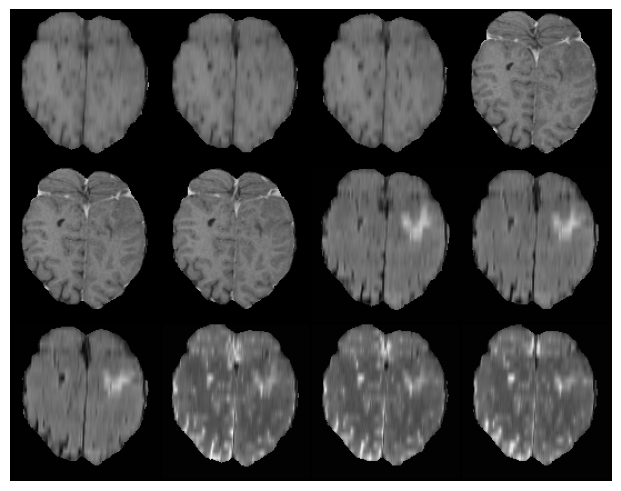

In [9]:
qimshow_batch(loader_around_seq(ds[123])[0])

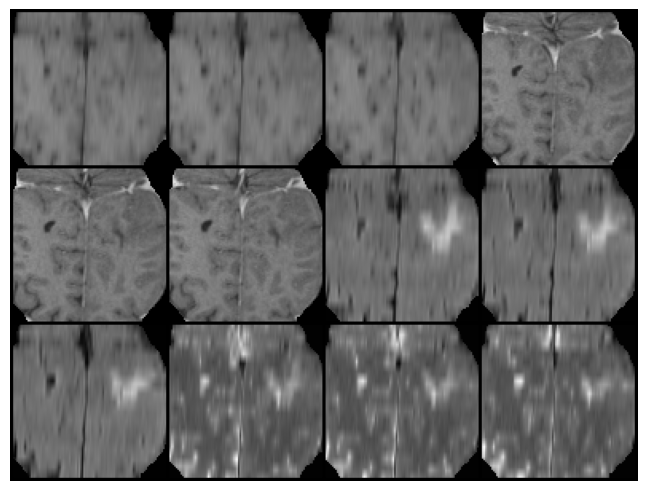

In [10]:
qimshow_batch(randcrop(loader_around_seq(ds[123]))[0])